#                                   Description Triangle Algorithm                                   #
                                        
####################### each Crownstone #######################                           

1a: Scan for surrounding nodes, store the UUID and the RSSI, and filter on RSSI if needed \
1b: Communicate with all the surrounding nodes, request RSSI and update the edges in the formed array/table \
#------------------->: Edge(node_src/node_dst/RSSI) 

2: If 2 edges are formed, Try making a triangle, by asking both edge_Dst if they can see each other \
2a Example: start at the top of the list, take a = list(i) and b = list(i+1) / two best connections, like c1/c2/-45 and c1/c3/-47 \
2b sends a message to both Crownstones, in this example c2 and c3, to ask if they can see each other in their surrounding nodes list \
2c If there is a node/vertice match, make a triangle with pointers to the edges \
#-------------------> Triangle(edgeP1/edgeP2/edgeP3) 

After forming all triangles: \
1: Go over every triangle from the triangle List and for each edge, add a triangle to a specific edge in adjacent triangle dict, with the class AdjTriangles \
2a: Each adjacent, will have otherCoord for his base dest. node, base alti x which is the altitude x coord that also lays on the axis as itself and otherCoord, \
2b: and store the altitude length that is perpendicular to the base edge, that starts/ends in the third node \
3: the map angle/Dihedral angle between two adjacent triangles, whereby the first is set as default in the XY plane, is calculated for map plotting 

####################### Communication ####################### 
                                        
Between two Crownstones:
* RequestNodeSearch: \
1: Request: a specific Crownstone checks if Node is visible in its Surrounding nodes list \
<->  \
2: Answer: specific Crownstone connection from the surrounding nodes list tuple in the format: (theAksedNode/RSSI) 

* requestTriangleSearch: \
1: Request: check if a specific edge exists in one of the edges of a triangle from the internal triangle List on the asked node \
<->  \
2: Answer: the specific Crownstone triangle containing the edge, the Triangle object has multiple pre-calculate usable values 



Mesh message between all Crownstones:  

* Global request for exchange of triangles to Hub 
* Every Cronwstone sends its best triangles (max 3-5) 


####################### Processing/Mapping ####################### 

All adjacent mapping structures will be sent to the hub. The hub will further process the triangles to a map by linking the structures with common edges.

In [61]:
# Run once to install all packages needed
# %pip install ipympl, matplotlib, networkx, pandas, numpy 

In [62]:
%matplotlib widget

import random
from random import normalvariate
import math
from math import sqrt, log10
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import networkx as nx
from IPython.display import display, clear_output
import ipywidgets as widgets
from collections import Counter
import threading
import time

In [63]:
#-----------------------------------------#

random.seed(7)

office_width = 5
office_length = 5
office_height = 3

num_nodes = 0 # if 0, take RefNodeCoords

# RefNodeCoords = [(0,0,0),(3,0,0),(0,3,0),(3,3,0),(6,0,0),(6,3,0),(1.5,1.5,2),(4.5,1.5,2)] # double pyramid
RefNodeCoords = [(0,0,0),(4,0,0),(3.5,2,0),(1.5,3,2)] # Tetraeder
# RefNodeCoords = [(5,5,0),(1,2,0),(1,9.5,0),(7,9,0),(9.5,1.5,0)] # Flat Umbrella
# RefNodeCoords = [(0,0,0),(4,0,0),(3.5,2,0)] # Simple Triangle

maxTriangles = 25

RSSI = False # True if using RSSI, False if using distance

#-----------------------------------------#

In [64]:
# Plot the reference node network
def compareGraph3D(Network_Dict, RefNode_List):
    G = nx.Graph()

    i = 0
    for nodeID, edges in Network_Dict.items():
        G.add_node(nodeID, pos=RefNode_List[i])
        for edge in edges:
            G.add_edge(edge.src.uuid, edge.dst.uuid, Rssi=edge.rssi)
        i += 1

    pos = nx.get_node_attributes(G, 'pos')
    rssi = nx.get_edge_attributes(G, "Rssi")

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis

    # Draw nodes as scatter plot and text labels
    for nodeID, coords in pos.items():
        ax.scatter(*coords, c="blue", s=100, marker='o')
        ax.text(*coords, f'Node {nodeID}\n({coords[0]}, {coords[1]}, {coords[2]})', ha='center', va='bottom')

    # Draw edges in 3D
    for edge in G.edges():
        xs, ys, zs = zip(*[pos[edge[i]] for i in range(2)])
        ax.plot(xs, ys, zs, color='black')
        rssi_value = rssi.get(edge, "")
        ax.text(sum(xs)/2,sum(ys)/2,sum(zs)/2, f"{rssi_value:.3f}", color='red')

    ax.set_title("Node plot with signal strength (RSSI) (3D)")
    plt.show()

# Convert the length between two coordinates to RSSI
def distance_to_rssi(nodeCoord1, nodeCoord2):
    c1x, c1y, c1z = nodeCoord1
    c2x, c2y, c2z = nodeCoord2
    distance = math.sqrt((c1x-c2x)**2 + (c1y-c2y)**2 + (c1z-c2z)**2)
    # noise = normalvariate(0, sqrt(20))
    noise = 0
    rssi = -70 - 10 * 2.0 * log10(distance) + noise
    if RSSI:
        return rssi
    else:
        return distance


# Convert RSSI into distance, for now a log function or later try neural net conversion
def rssi_to_distance(rssi):
    if RSSI:
        return (10**((-rssi-70)/(20)))
    else:
        return rssi

# Planar Roll rotation X
def roll(phi):
    phi = np.deg2rad(phi)
    return np.array([[1, 0, 0],
                     [0, np.cos(phi), -np.sin(phi)],
                     [0, np.sin(phi), np.cos(phi)]])

# Planar PITCH rotation Y
def pitch(theta):
    theta = np.deg2rad(theta)
    return np.array([[np.cos(theta), 0, np.sin(theta)],
                     [0, 1, 0],
                     [-np.sin(theta), 0, np.cos(theta)]])

# Planar YAW rotation Z
def yaw(psi):
    psi = np.deg2rad(psi)
    return np.array([[np.cos(psi), -np.sin(psi), 0],
                    [np.sin(psi), np.cos(psi), 0],
                    [0, 0, 1]])

In [65]:
# Node class, which represents a individual Crownstone
class Node:

    def __init__(self, HWuuid: str):
        self.uuid = HWuuid
        self.coord = (0,0,0)
        self.SurNodes = [] # list of (node reference, rssi)
        self.adjEdgeList = []
        self.oppEdgeList = []
        self.triangleList = []
        self.adjTrianglesDict = {}
   
    def __repr__(self):
        return str(self)
    
    def __str__(self) -> str:
        edges_str = ', '.join(map(str, self.adjEdgeList))
        triangles_str = '\n'.join(map(str, self.triangleList))
        nodes_str = ', '.join(map(str, [node.uuid for node, rssi in self.SurNodes])) 
        oppos_str = ', '.join(map(str, self.oppEdgeList)) 
        line = "------------------------------------------------------------------------------------------------\n"
        return f"{line}Node uuid={self.uuid}:{self.coord} [:] Surrounding Nodes= {nodes_str}, Edgelist= {edges_str}\n\nTriangleList:\n{triangles_str}\n\nOpposite edges={oppos_str} [:]\n"
    
    # Print all node information
    def printNodeInfo(self):
        print(self)
        if len(self.adjTrianglesDict) == 0:
            print("No adj triangles dict")
            return
        
        print(f"Adjacent triangles of {self.uuid}:") 
        for edge, adj_list in self.adjTrianglesDict.items():
            print(f"Edge {edge.id}:")
            for adj in adj_list:
                print(adj)
        print("------------------------------------------------------------------------------------------------\n")
      
    def compare(self, other: object):
        return self.uuid == other.uuid
    
    # Initial scan for surrounding nodes in the environment 
    def scanSurroundings(self, network_edges):
        surNodeSet = set()
        for edge in network_edges[self.uuid]:
            surNodeSet.add((edge.dst,edge.rssi))
        self.SurNodes = sorted(surNodeSet, key=lambda x: x[1], reverse=RSSI)

    # Node search request for searched_Node at target_node
    def requestNodeSearch(self, target_node, searched_Node):
        # send BLE message to target and wait for response
        found = target_node.nodeSearch(searched_Node)
        if (found == False):
            print(f"{self.uuid}: Node NOT visible")
        else:
            return found # (Node, RSSI)

    # NodeSearch response, checks if requested node is visible in surroundings
    def nodeSearch(self, checkFor: object) -> tuple:
        for surNode in self.SurNodes:
            if surNode[0] == checkFor:
                return surNode
        return False
    
    # Checks if edge is in current list of edges
    def checkEdge(self, check_edgeDst):
        for edge in self.adjEdgeList:
            if edge.dst == check_edgeDst:
                return edge
        return False
    
    # Make a new edge from the supplied nodes and add it to the adjEdgeList if it does not exist already
    def addEdge(self, node1, node2, rssi):
        # check if Edge not already exist
        if self.checkEdge(node2) == False:
            newEdge = Edge(node1, node2, rssi)
            self.adjEdgeList.append(newEdge)
            return True
        else:
            # print("Duplicate!")
            return False

    # Creates an edge with other_sur by making a requestNodeSearch() for itself at other_sur.
    # The edge will be stored in the adjacent edge list, it uses the rssi of other_sur. 
    # List will be sorted due to sorted sur_nodes
    def createEdgeWith(self, other_Sur: tuple):
        check = self.requestNodeSearch(other_Sur[0],self)
        if check == False:
            print(f"{self.uuid}: Can not form edge, Node not visible!")
            return False
        else:
            return self.addEdge(self,other_Sur[0],other_Sur[1])
    
    # Check if triangle is already added to internal trianglelist
    def checkTriangle(self, checkTriangle):
        for triangle in self.triangleList:
            if triangle == checkTriangle:
                return True
        return False
    
    # Internal triangle/opposite_edge search in all triangles of the trianglelist
    def triangleSearch(self, opposite_edge):
        for triangle in self.triangleList:
            if triangle.hasEdge(opposite_edge):
                return triangle
        return False  
    
     # Triangle search request for target, should actually return the needed values instead of whole Triangle object
    def requestTriangleSearch(self, target_Node, searched_Edge):
        # send BLE message to target and wait for response
        return target_Node.triangleSearch(searched_Edge)

    # Make a new triangle from the supplied edges and add it to the trianglist if it does not exist already, 
    def addTriangle(self, edge1,edge2,common_edge, max_triangles):
        temp = Triangle(edge1,edge2,common_edge)
        # check if triangle not already exist, false is not in list
        if self.checkTriangle(temp) == False and temp.area > 0.5:
            self.oppEdgeList.append(common_edge)
            self.oppEdgeList.sort(key=lambda x: x.rssi,reverse=RSSI)
            self.triangleList.append(temp)
            self.triangleList.sort(key=lambda x: x.area, reverse=False)
            return True
        else:
            # print("Duplicate!")
            return False

    # create temporary triangle to make altitude and angle calculations    
    def createTempTriangle(self, defaultOtherNode, otherNode):
        checkForOther = self.requestNodeSearch(defaultOtherNode,otherNode)
        checkForDef = self.requestNodeSearch(otherNode,defaultOtherNode)
        if checkForOther == False or checkForDef == False:
            print(f"{self.uuid}: Check Error {defaultOtherNode.uuid} {otherNode.uuid}")
            return False
        if checkForOther[0].compare(otherNode) and checkForDef[0].compare(defaultOtherNode):
            common_edge = Edge(defaultOtherNode,otherNode,checkForDef[1])       
            temp = Triangle(Edge(self,defaultOtherNode,self.nodeSearch(defaultOtherNode)[1]),Edge(self,otherNode,self.nodeSearch(otherNode)[1]),common_edge)
            # print(f'{self.uuid}: Temp triangle = {temp}')
            return temp
        else:
            print(f"{self.uuid}: Compare Error {defaultOtherNode.uuid} {otherNode.uuid}")
            return False
        
    # Triangle search request for target
    def requestTempTriangle(self, target_Node, defaultNode, otherNode):
        # send BLE message to target and wait for response
        return target_Node.createTempTriangle(defaultNode,otherNode)

    # Creates a Triangle with self, dst1 and dst2, by making a requestNodeSearch() at dst1 for dst2, and at dst2 for dst1.
    # If there is mutual agreement, an edge between dst1 and dst2 will be made and stored in opposite edge list. 
    # The three edges will be added togheter to form a new triangle
    def createTriangleWith(self, edge1, edge2, max_triangles):
        dst1, dst2 = edge1.dst, edge2.dst
        if self.compare(dst1) or self.compare(dst2):
            print(f"{self.uuid}: Can not make Triangle with itself")
            return False
        
        checkForDst2 = self.requestNodeSearch(dst1,dst2)
        checkForDst1 = self.requestNodeSearch(dst2,dst1)
        if checkForDst2 == False or checkForDst1 == False:
            print(f"{self.uuid}: Triangle not possible, no common edge")
            return False
        if checkForDst2[0].compare(dst2) and checkForDst1[0].compare(dst1):
            common_edge = Edge(dst1,dst2,checkForDst1[1])
            return self.addTriangle(edge1,edge2,common_edge, max_triangles)


    # This procedure will walk all the nodes and will make N triangles. routine: iterate surnodes, make edge from first, add them to edgelist, 
    # check if edge sees other edge, if True, form edges and make triangle, add triangle to trianglelist
    def triangleProcedure(self, max_triangles):
        surCount = len(self.SurNodes)
        # self.triangleList = array(max_triangles) in C++ allocate array of max_triangles 
        for i in range(surCount):
            for j in range(i+1, surCount):
                self.createEdgeWith(self.SurNodes[i]) # tuple(node,rssi)
                self.createEdgeWith(self.SurNodes[j])
                edgeP1 = self.checkEdge(self.SurNodes[i][0]) # search on dst node
                edgeP2 = self.checkEdge(self.SurNodes[j][0]) 
                self.createTriangleWith(edgeP1,edgeP2, max_triangles)
                if len(self.triangleList) == max_triangles:
                    # TODO: replace when lower weight, max_triangles
                    return
    
    # Links all triangles from trianglelist to individual edges from the edgelist, so edge(AB) has adj
    def createAdjTriangles(self):
        if len(self.adjEdgeList) == 0 or len(self.triangleList) == 0:
            print(f"{self.uuid}: NO edges or triangles")
            return False 
        
        triangle_dict = {}
        for base_edge in self.adjEdgeList:
            for triangle in self.triangleList:
                if triangle.hasEdge(base_edge):
                    adjTriangle = Adjacent(triangle)
                    if base_edge not in triangle_dict:
                        adjTriangle.setCoord((base_edge.dst.uuid,base_edge.dist))
                        triangle_dict[base_edge] = [adjTriangle]
                    else:
                        triangle_dict[base_edge].append(adjTriangle)          
        self.adjTrianglesDict = triangle_dict
    

    # ABC and ABD: From the two adjacent nodes C and D, get the height and xpos of the altitude, calculate dXpos
    # Get the distance between C and D, together with dXpos calculate the translation with pythagoras.
    # Dihedral angle calculation with Triangle()
    def getMapAngle(self, defaultOtherNode, otherNode,base_altiX,altiX,base_altiH,altiH):
        reqTri = self.triangleSearch(Edge(defaultOtherNode,otherNode,0)) # first check internal
        if reqTri == False:
            # call make temp triangle, for calculation of altitude -> angle
            reqTri = self.createTempTriangle(defaultOtherNode,otherNode)
            if reqTri == False:
                return None
            
        nodeDist = reqTri.edges[2].dist
        deltaX = abs(base_altiX - altiX)
        pyth = max(0, nodeDist**2 - deltaX**2)

        translation = math.sqrt(pyth)
        a, b, c = translation, base_altiH, altiH
        p = max(-1, min(1, (b**2 + c**2 - a**2) / (2 * b * c)))
        mapAngle = np.rad2deg(np.arccos(p)) 
        return mapAngle
    

    # Requests altitude position and height from the askNode, for example: you are A in triangle ABC, base_edge AB, askNode C, check if it has triangle with the values for altitude information 
    def mapAltiRequest(self, askNode, base_edge, self_angle):
        reqTri = self.requestTriangleSearch(askNode, base_edge)
        if reqTri == False:
            # call make temp triangle at target_node, for calculation of altitude -> angle
            reqTri = self.requestTempTriangle(askNode,base_edge.src,base_edge.dst)
            if reqTri == False:
                return None, None

        if reqTri.altiX[0][0] == self.uuid: # return the x pos from perspective self, to the asked node
            if self_angle > 90:
                return (reqTri.altiX[0][0],-reqTri.altiX[0][1]), reqTri.altiH # list(tuple(node,-alti),tuple(node,alti))
            else:
                return reqTri.altiX[0], reqTri.altiH # list(tuple(node,alti),tuple(node,alti))
        else:
            if self_angle > 90:
                return (reqTri.altiX[1][0],-reqTri.altiX[1][1]), reqTri.altiH # list(tuple(node,-alti),tuple(node,alti))
            else:
                return reqTri.altiX[1], reqTri.altiH # list(tuple(node,alti),tuple(node,alti))
    

    # Iterates on the adjacent triangles, set the first on XY/default and calculate for the following triangles the angle between default, altiX, altiH 
    def mapAdjacents(self):
        for base_edge, adj_list in self.adjTrianglesDict.items():
            defaultOtherNode = adj_list[0].triangle.getLastNode(base_edge)
            selfAngle = adj_list[0].triangle.angle[1]  # tuple(node,angle)
            base_altiX, base_altiH = self.mapAltiRequest(defaultOtherNode,base_edge, selfAngle)

            if base_altiX == None or base_altiH == None:
                print(f"{self.uuid}: mapAltiRequest failed!")
            else:
                adj_list[0].setAltiH(base_altiH)
                adj_list[0].setAltiX(base_altiX)        
            for i in range(1,len(adj_list)):
                otherNode = adj_list[i].triangle.getLastNode(base_edge)
                selfAngle = adj_list[i].triangle.angle[1] # tuple(node,angle)
                altiX, altiH = self.mapAltiRequest(otherNode,base_edge,selfAngle)
            
                if altiX == None or altiH == None:
                    print(f"{self.uuid}: mapAltiRequest failed!")
                else:
                    adj_list[i].setAltiH(altiH)
                    adj_list[i].setAltiX(altiX)
                    adj_list[i].setCoord(('X',0))

                    angle = self.getMapAngle(defaultOtherNode,otherNode,base_altiX[1],altiX[1],base_altiH[1],altiH[1])
                    if angle == None:
                        print(f"{self.uuid}: mapAngle failed!")
                    else:
                        adj_list[i].setAngle(angle)


    def init(self, network_edges, max_triangles):
        self.scanSurroundings(network_edges)
        time.sleep(3)
        self.triangleProcedure(max_triangles)
        time.sleep(3)

    def main(self, network_edges, max_triangles):
        self.init(network_edges, max_triangles)
        # should only be called after every node is done forming triangles! due to checkedge of triangle for altitude
        self.createAdjTriangles()
        self.mapAdjacents()
        time.sleep(3)
        self.printNodeInfo()

       

class Edge:

    def __init__(self, src: Node, dst: Node, rssi):
        self.id = (src.uuid,dst.uuid)
        self.src = src
        self.dst = dst
        self.rssi = rssi
        self.dist = rssi_to_distance(rssi)

    def __str__(self) -> str:
        return f"({self.src.uuid},{self.dst.uuid},{self.dist:.3f})"
    
    def __repr__(self):
        return str(self)
    
    def __hash__(self) -> int:
        return hash(self.id)
    
    def __eq__(self, other: object) -> bool:
        return self.__hash__() == other.__hash__()
    
    def compare(self, other: object):
        self_src_uuid, self_dst_uuid = self.src.uuid, self.dst.uuid
        other_src_uuid, other_dst_uuid = other.src.uuid, other.dst.uuid

        return ((self_src_uuid == other_src_uuid and self_dst_uuid == other_dst_uuid) or
            (self_src_uuid == other_dst_uuid and self_dst_uuid == other_src_uuid)
        )

# triangles are stored locally and node specific, iow: edge are in the orientation of the node, ab, ac, bc
class Triangle:

    def __init__(self, edge1: Edge, edge2: Edge, edge3: Edge):
        self.edges = [edge1,edge2,edge3]
        self.area = self.getArea()
        self.nodes = [edge1.src, edge3.src, edge3.dst] # startnode|opposite edge src node|opposite edge dst node
        self.unique = sorted(set(node.uuid for node in self.nodes))
        self.ID = "|".join(map(str, self.unique))

        self.angle = self.getAngle()
        self.altiH = self.getAltitudeH()
        self.altiX = self.getAltitudeX() # from both adjacent edge perspectives, list of two

    def __str__(self) -> str:
        edges_str = ', '.join(map(str, self.edges))
        return f"Triangle {self.ID}: Area= {self.area:.3f}, Edges= {edges_str}, Angles=({self.angle[0]},{self.angle[1]:.3f}), Altitude=(x=[(To {self.altiX[0][0]},{self.altiX[0][1]:.3f}),(To {self.altiX[1][0]},{self.altiX[1][1]:.3f})], H=({self.altiH[0]},{self.altiH[1]:.3f}))"
    
    def __repr__(self):
        return str(self)
    
    def __hash__(self) -> int:
        return hash(f'{self.unique}')
      
    def __eq__(self, other: object) -> bool:
        return self.__hash__() == other.__hash__()
    
    # Checks if triangle has the edge_to_check in its edges
    def hasEdge(self, edge_to_check: Edge):
        for i, edge in enumerate(self.edges):
            if edge.compare(edge_to_check):
                return True
        return False

    # Returns the last node spanning the triangle, based on the base_edge src and dst node
    def getLastNode(self, base_edge: Edge):
        for node in self.nodes:
            if node != base_edge.src and node != base_edge.dst:
                return node         

    # Calculates the angle of the triangle from the node perspective corner     
    def getAngle(self): # ab0 ac1 bc2              
        a = self.edges[2].dist # edge bc  
        b = self.edges[1].dist # edge ac  
        c = self.edges[0].dist # edge ab
        p = (b**2+c**2-a**2)/(2*b*c)
        q = max(-1, min(1, p))
        angle = np.rad2deg(np.arccos(q))
        return (self.edges[0].src.uuid, angle)
    
    # calculate the area of the triangle with Heron's formula
    def getArea(self):
        a = self.edges[2].dist # edge bc  
        b = self.edges[1].dist # edge ac  
        c = self.edges[0].dist # edge ab
        # Heron's formula 
        s = (a + b + c) / 2
        div = s * (s - a) * (s - b) * (s - c)
        # check if nodes are inline -> angle 0 or 180
        if div < 0: 
            div = 0
        return math.sqrt(div) 

    # Calculates the altitude height of the triangle from node perspective with Heron's formula, see getArea() 
    # for example: self = A, ABC got edge ab,ac,bc -> altitude height is from corner A to side bc       
    def getAltitudeH(self):
        a = self.edges[2].dist # opposite edge bc         
        height = (2 * self.area) / a
        return (self.edges[0].src.uuid, height)
    
    # Calculates the altitude X position with pythogoras from the node perspective corner onto the opposite edge. 
    # for example: self = A, ABC got edge ab,ac,bc -> altitude x position is from perspective of A, and lays on the opposite edge (0,0,0)->(x,0,0)   
    def getAltitudeX(self):  # ab0 ac1 bc2
        ab_squared = self.edges[0].dist ** 2
        ac_squared = self.edges[1].dist ** 2
        hA_squared = self.altiH[1] ** 2

        # Pythagoras formula
        divB = ab_squared - hA_squared
        divC = ac_squared - hA_squared

        divB = math.sqrt(max(divB, 0))
        divC = math.sqrt(max(divC, 0))

        return [
            (self.edges[0].dst.uuid, divB),
            (self.edges[1].dst.uuid, divC)
        ]


class Adjacent:

    def __init__(self, triangle: Triangle):
        self.triangle = triangle
        self.mapAngle = 0
        self.otherCoord = (None,0)
        self.basealtiX = (None,None)
        self.basealtiH = (None,None)

    def __str__(self) -> str:
        return f"Triangle({self.triangle.ID}): base-coord=({self.otherCoord[0]},{self.otherCoord[1]:.3f}), map angle= {self.mapAngle:.3f} | xpos altitude=({self.basealtiX[0]},{self.basealtiX[1]:.3f}) | altitude height=({self.basealtiH[0]},{self.basealtiH[1]:.3f}) "
    
    def __repr__(self):
        return str(self)
    
    def setCoord(self, coord):
        self.otherCoord = coord
    
    def setAngle(self, angle):
        self.mapAngle = angle

    def setAltiX(self, xpos):
        self.basealtiX = xpos
    
    def setAltiH(self, height):
        self.basealtiH = height

<h1> Setup: Make n nodes and create edge list that represents the current network </h1>

In [66]:
def printNodes(node_List):
    print("List of nodes:")
    for node in node_List:
        print(node)
    print()

List of nodes:
------------------------------------------------------------------------------------------------
Node uuid=A:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= 

TriangleList:


Opposite edges= [:]

------------------------------------------------------------------------------------------------
Node uuid=B:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= 

TriangleList:


Opposite edges= [:]

------------------------------------------------------------------------------------------------
Node uuid=C:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= 

TriangleList:


Opposite edges= [:]

------------------------------------------------------------------------------------------------
Node uuid=D:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= 

TriangleList:


Opposite edges= [:]


Reference Network Edges:
Node A:= Edges[(A,D,3.905), (A,B,4.000), (A,C,4.031)]
Node B:= Edges[(B,C,2.062), (B,A,4.000), (B,D,4.387)]
Node C:= Edges[(C,B,2.062), (C,D,3.000), (C,A,4.031)]
Node D:= Edges[(D,C,3.000

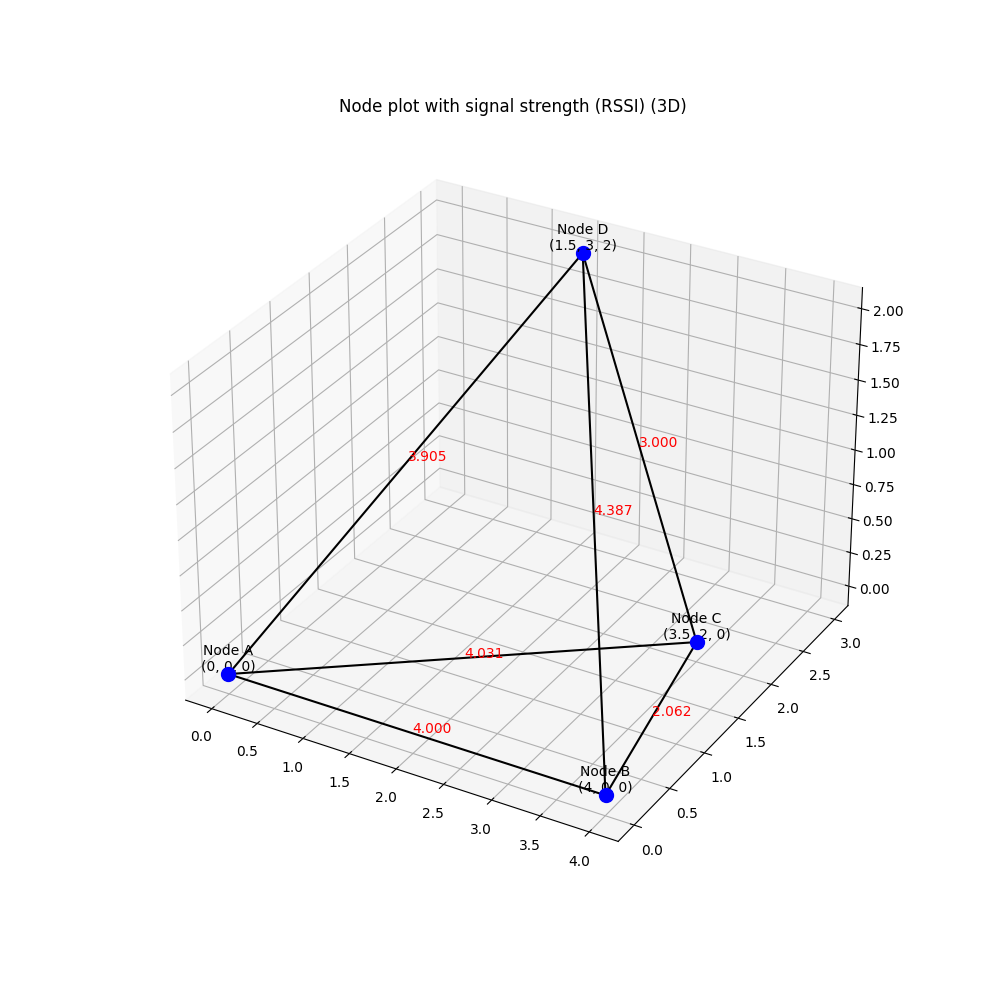

In [67]:
nodeList = []

names = list(map(chr,range(ord('A'),ord('Z')+1)))

if num_nodes == 0:
    for i in range(len(RefNodeCoords)): 
        nodeList.append(Node(names[i]))
else:
    coordlist = []
    for i in range(num_nodes):
        nodeList.append(Node(names[i]))
        x = round(random.uniform(0, office_width) * 2) / 2
        y = round(random.uniform(0, office_length) * 2) / 2
        z = round(random.uniform(0, office_height) * 2) / 2
        coordlist.append((x,y,z))
       
    RefNodeCoords = coordlist

printNodes(nodeList)

NetworkEdges = {}
for i in range(len(nodeList)):
    table = []
    for j in range(len(nodeList)):
        if nodeList[i] != nodeList[j]:
            table.append(Edge(nodeList[i], nodeList[j], distance_to_rssi(RefNodeCoords[i],RefNodeCoords[j])))
    table = sorted(table, key=lambda x: x.rssi, reverse=RSSI) # if rssi set True
    NetworkEdges[nodeList[i].uuid] = table

print('Reference Network Edges:')
for key, edges in NetworkEdges.items():
    print(f'Node {key}:= Edges{edges}')

compareGraph3D(NetworkEdges,RefNodeCoords)

<h1> Main: getting all node data </h1>

In [68]:
# activate nodes, print function in parallel with Threading
thread_list = []
for i in range(len(nodeList)):
    thread = threading.Thread(target=nodeList[i].main, args=(NetworkEdges,maxTriangles))
    thread_list.append(thread)
    thread.start()

for thread in thread_list:
    thread.join()

------------------------------------------------------------------------------------------------
Node uuid=A:(0, 0, 0) [:] Surrounding Nodes= D, B, C, Edgelist= (A,D,3.905), (A,B,4.000), (A,C,4.031)

TriangleList:
Triangle A|B|C: Area= 4.000, Edges= (A,B,4.000), (A,C,4.031), (B,C,2.062), Angles=(A,29.745), Altitude=(x=[(To B,0.970),(To C,1.091)], H=(A,3.881))
Triangle A|C|D: Area= 5.506, Edges= (A,D,3.905), (A,C,4.031), (D,C,3.000), Angles=(A,44.386), Altitude=(x=[(To D,1.333),(To C,1.667)], H=(A,3.670))
Triangle A|B|D: Area= 7.211, Edges= (A,D,3.905), (A,B,4.000), (D,B,4.387), Angles=(A,67.411), Altitude=(x=[(To D,2.108),(To B,2.279)], H=(A,3.287))

Opposite edges=(B,C,2.062), (D,C,3.000), (D,B,4.387) [:]

Adjacent triangles of A:
Edge ('A', 'D'):
Triangle(A|C|D): base-coord=(D,3.905), map angle= 0.000 | xpos altitude=(A,2.881) | altitude height=(C,2.820) 
Triangle(A|B|D): base-coord=(X,0.000), map angle= 23.169 | xpos altitude=(A,1.536) | altitude height=(B,3.693) 
Edge ('A', 'B'):
T

<h1> Visualizing node data </h1>

In [69]:
def mapPlot(Edge_list, node_Dict):
    G = nx.Graph()

    for node in node_Dict.items():
        G.add_node(node[0], pos=node[1])

    for edge in Edge_list:
        G.add_edge(edge.src.uuid, edge.dst.uuid, Rssi=edge.rssi)

    pos = nx.get_node_attributes(G, 'pos')
    rssi = nx.get_edge_attributes(G, "Rssi")

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis

    # Draw nodes as scatter plot and text labels
    for nodeID, coords in pos.items():
        ax.scatter(*coords, c="blue", s=100, marker='o')
        ax.text(*coords, f'Node {nodeID}\n({coords[0]}, {coords[1]}, {coords[2]})', ha='center', va='bottom')

    # Draw edges in 3D
    for edge in G.edges():
        xs, ys, zs = zip(*[pos[edge[i]] for i in range(2)])
        ax.plot(xs, ys, zs, color='black')
        rssi_value = rssi.get(edge, "")
        ax.text(sum(xs)/2,sum(ys)/2,sum(zs)/2, f"{rssi_value:.3f}", color='red')

    ax.set_title("Adjacent map of visible nodes (3D)")
    plt.show()

In [70]:
# nodeA = nodeList[0]
# index = 0

# keyA0 = list(nodeA.adjTrianglesDict.keys())[index]
# adjListA = list(nodeA.adjTrianglesDict.values())[index]

# print(f'A :=> Base edge: {keyA0.id}:')
# for adj in adjListA:
#     print(adj)
# print()

# mapCoords = {nodeA.uuid: nodeA.coord,}

# mapEdgeSet = []
# # go over all triangles and place the coords on the x-axis and rotate, also make list of all edges from all adj triangles
# for i, adj in enumerate(adjListA):
#     if i == 0:
#         mapCoords.update({adj.otherCoord[0]:(round(adj.otherCoord[1],3),0.000,0.000)})
    
#     coord = (adj.basealtiX[1],adj.basealtiH[1],0.000) 
#     rotation = roll(adj.mapAngle) #.round(decimals=2)
#     point = np.array([coord[0], coord[1], coord[2]])    
#     translated = np.dot(rotation, point)
#     mapCoords.update({adj.basealtiH[0]:(round(translated[0],3),round(translated[1],3),round(translated[2],3))})
#     mapEdgeSet.extend(edge for edge in adj.triangle.edges if not any(edge.compare(existing_edge) for existing_edge in mapEdgeSet))

# sorted_mapCoords = dict(sorted(mapCoords.items()))

# print('Plotting nodes (x,y,z) with respect to the base edge:')
# for coord in sorted_mapCoords.items():
#     print(f"Node {coord[0]}: ({coord[1][0]:.3f},{coord[1][1]:.3f},{coord[1][2]:.3f})")
# print()

# print(f"All edges from base triangles ({len(mapEdgeSet)}):")
# for edge in list(mapEdgeSet):
#     print(edge)

# mapPlot(list(mapEdgeSet),mapCoords)

A :=> Base edge: ('A', 'D'):
Triangle(A|C|D): base-coord=(D,3.905), map angle= 0.000 | xpos altitude=(A,2.881) | altitude height=(C,2.820) 
Triangle(A|B|D): base-coord=(X,0.000), map angle= 23.169 | xpos altitude=(A,1.536) | altitude height=(B,3.693) 



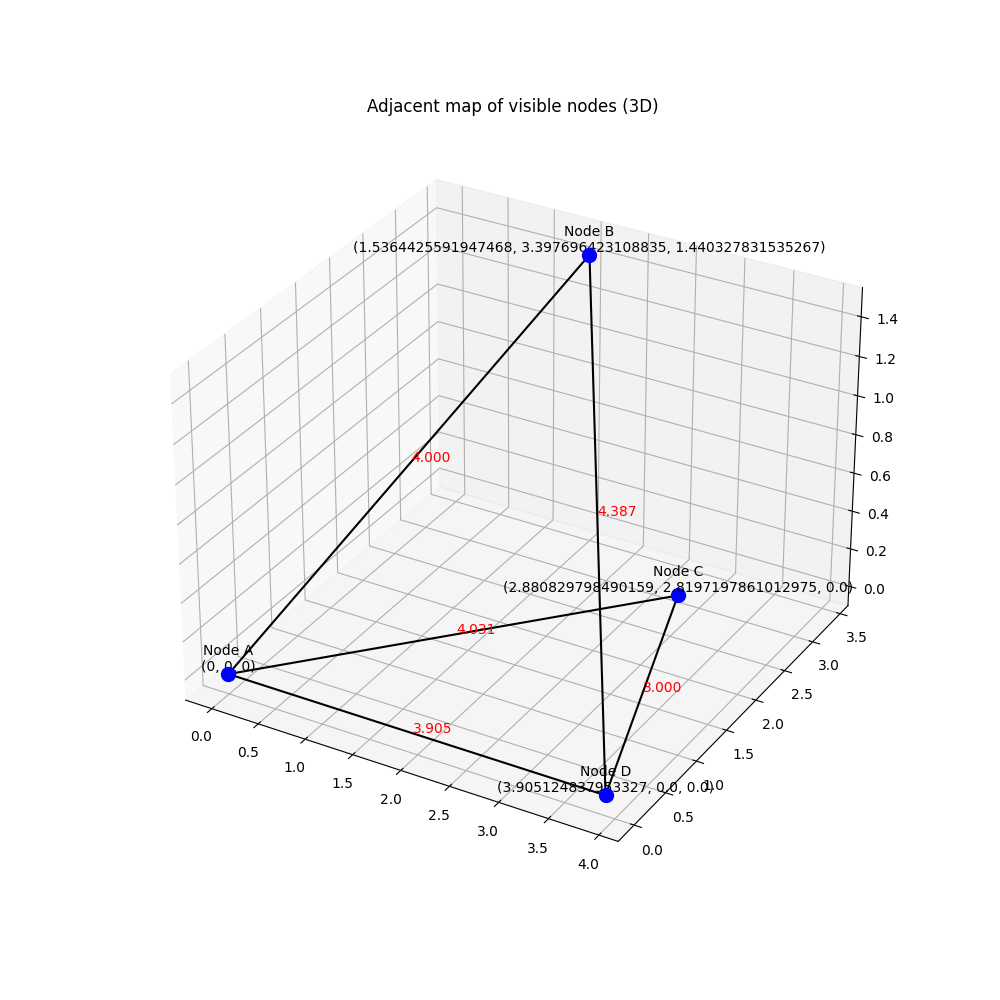

A :=> Base edge: ('A', 'B'):
Triangle(A|B|C): base-coord=(B,4.000), map angle= 0.000 | xpos altitude=(A,3.500) | altitude height=(C,2.000) 
Triangle(A|B|D): base-coord=(X,0.000), map angle= 33.690 | xpos altitude=(A,1.500) | altitude height=(D,3.606) 



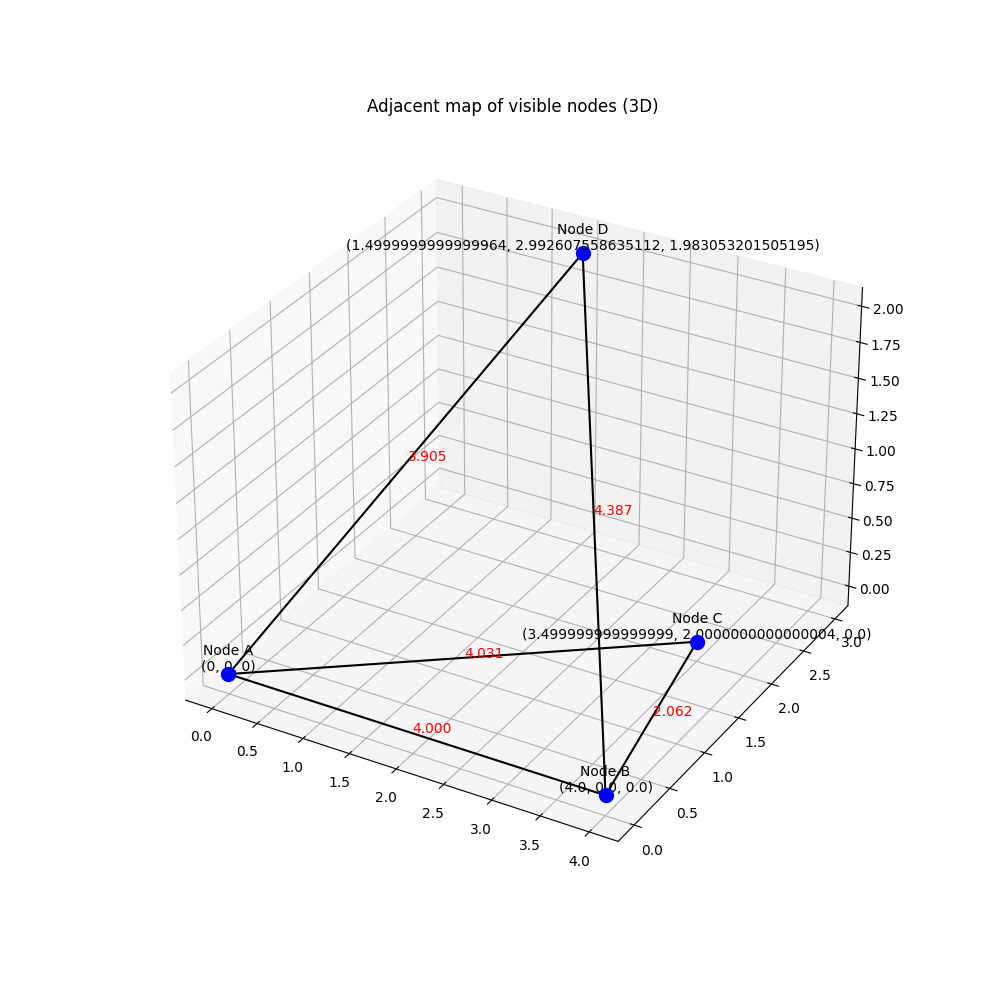

A :=> Base edge: ('A', 'C'):
Triangle(A|B|C): base-coord=(C,4.031), map angle= 0.000 | xpos altitude=(A,3.473) | altitude height=(B,1.985) 
Triangle(A|C|D): base-coord=(X,0.000), map angle= 132.931 | xpos altitude=(A,2.791) | altitude height=(D,2.732) 



C:\Users\chiel\AppData\Local\Temp\ipykernel_16564\1638470220.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 10))


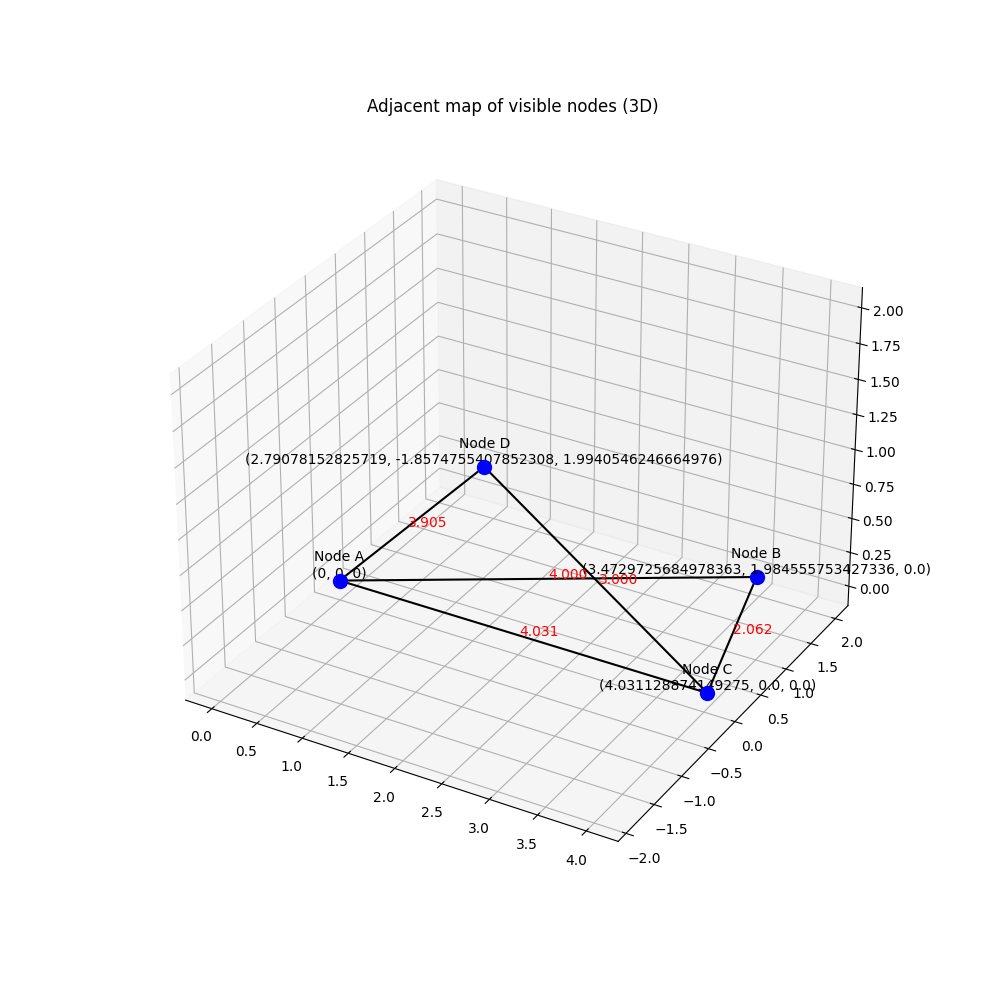

Plotting nodes (x,y,z) of each base edge:
For edge ('A', 'D'):
Node A: (0.000,0.000,0.000)
Node B: (1.536,3.398,1.440)
Node C: (2.881,2.820,0.000)
Node D: (3.905,0.000,0.000)

For edge ('A', 'B'):
Node A: (0.000,0.000,0.000)
Node B: (4.000,0.000,0.000)
Node C: (3.500,2.000,0.000)
Node D: (1.500,2.993,1.983)

For edge ('A', 'C'):
Node A: (0.000,0.000,0.000)
Node B: (3.473,1.985,0.000)
Node C: (4.031,0.000,0.000)
Node D: (2.791,-1.857,1.994)



In [71]:
nodeA = nodeList[0]

mapCoordsDict = {}
mapEdgeSetDict = {}

for i in range(len(nodeA.adjTrianglesDict)):

    key = list(nodeA.adjTrianglesDict.keys())[i]
    adjList = list(nodeA.adjTrianglesDict.values())[i]

    print(f'A :=> Base edge: {key.id}:')
    for adj in adjList:
        print(adj)
    print()

    mapCoords = {nodeA.uuid: nodeA.coord,}
    mapEdgeSet = []
    
    # go over all triangles and place the coords on the x-axis and rotate, also make list of all edges from all adj triangles
    for i, adj in enumerate(adjList):
        if i == 0:
            mapCoords.update({adj.otherCoord[0]:(adj.otherCoord[1],0.000,0.000)})
        
        coord = (adj.basealtiX[1],adj.basealtiH[1],0.000) 
        rotation = roll(adj.mapAngle).round(decimals=2)
        point = np.array([coord[0], coord[1], coord[2]])    
        translated = np.dot(rotation, point)
        mapCoords.update({adj.basealtiH[0]:(translated[0],translated[1],translated[2])})
        mapEdgeSet.extend(edge for edge in adj.triangle.edges if not any(edge.compare(existing_edge) for existing_edge in mapEdgeSet))
    
    # mapCoordsDict.update( { key.id : sorted(mapCoords.items()) } )
    mapCoordsDict.update( { key.id : mapCoords})
    mapEdgeSetDict.update( { key.id : mapEdgeSet } )

    mapPlot(list(mapEdgeSet),mapCoords)

print('Plotting nodes (x,y,z) of each base edge:')
for edge, mapCoords in mapCoordsDict.items():
    print(f'For edge {edge}:')
    for coord in sorted(mapCoords.items()):
        print(f"Node {coord[0]}: ({coord[1][0]:.3f},{coord[1][1]:.3f},{coord[1][2]:.3f})")
    print()

In [75]:
def calculate_translation(original_positionB, desired_positionB):
    return tuple(original - desired for desired, original in zip(desired_positionB, original_positionB))

newCoordsDict = mapCoordsDict.copy()
index = 'D'
DefaultEdgeX = list(newCoordsDict.items())[0][1][index]
print(f'Default change D {DefaultEdgeX}\n')

for edge, coordinates in newCoordsDict.items():
    translation = calculate_translation(coordinates[index], DefaultEdgeX)
    # print(translation)
    for coord in coordinates.keys():
        if coord == 'A':
            continue
        if coord == index:
            coordinates.update({coord:DefaultEdgeX})
        else:
            coordinates.update({coord:calculate_translation(coordinates[coord], translation)})
    

print('Plotting new nodes (x,y,z) of each base edge:')
for edge, mapCoords in newCoordsDict.items():
    print(f'For edge {edge}:')
    for coord in sorted(mapCoords.items()):
        print(f"Node {coord[0]}: ({coord[1][0]:.3f},{coord[1][1]:.3f},{coord[1][2]:.3f})")
    print()

Default change D (3.905124837953327, 0.0, 0.0)

Plotting new nodes (x,y,z) of each base edge:
For edge ('A', 'D'):
Node A: (0.000,0.000,0.000)
Node B: (1.536,3.398,1.440)
Node C: (2.881,2.820,0.000)
Node D: (3.905,0.000,0.000)

For edge ('A', 'B'):
Node A: (0.000,0.000,0.000)
Node B: (6.405,-2.993,-1.983)
Node C: (5.905,-0.993,-1.983)
Node D: (3.905,0.000,0.000)

For edge ('A', 'C'):
Node A: (0.000,0.000,0.000)
Node B: (4.587,3.842,-1.994)
Node C: (5.145,1.857,-1.994)
Node D: (3.905,0.000,0.000)



In [73]:
# import numpy as np

# # Define the coordinates of the nodes
# nodes = {
#     'A': np.array([0.000, 0.000, 0.000]),
#     'B': np.array([1.543, 2.572, 0.000]),
#     'C': np.array([1.543, -0.926, 2.392]),
#     'D': np.array([3.087, 1.659, 2.387]),
#     'E': np.array([3.087, 5.145, 0.000]),
#     'F': np.array([4.630, 4.223, 2.378]),
#     'G': np.array([2.915, 0.000, 0.000]),
#     'H': np.array([4.459, 2.572, 0.000])
# }

# # Calculate the translation vector to move C to the origin
# translation_vector = -nodes['C']

# # Translate all nodes by the translation vector
# for node, coordinates in nodes.items():
#     nodes[node] = coordinates + translation_vector

# # Calculate the rotation matrix to align C to the new Z-axis
# C = nodes['C']
# theta_x = -np.arctan2(C[1], C[2])
# theta_y = np.arctan2(C[0], np.sqrt(C[1]**2 + C[2]**2))

# # Define rotation functions for X, Y, and Z axes
# def rotation_matrix_x(theta):
#     return np.array([[1, 0, 0],
#                      [0, np.cos(theta), -np.sin(theta)],
#                      [0, np.sin(theta), np.cos(theta)]])

# def rotation_matrix_y(theta):
#     return np.array([[np.cos(theta), 0, np.sin(theta)],
#                      [0, 1, 0],
#                      [-np.sin(theta), 0, np.cos(theta)]])

# def rotation_matrix_z(theta):
#     return np.array([[np.cos(theta), -np.sin(theta), 0],
#                      [np.sin(theta), np.cos(theta), 0],
#                      [0, 0, 1]])

# # Rotate all nodes to align C with the new Z-axis
# for node, coordinates in nodes.items():
#     R_x = rotation_matrix_x(theta_x)
#     R_y = rotation_matrix_y(theta_y)
#     rotated_coordinates = R_y.dot(R_x.dot(coordinates))
#     nodes[node] = rotated_coordinates

# # Print the updated coordinates
# for node, coordinates in nodes.items():
#     print(f'Node {node}: ({coordinates[0]:.3f}, {coordinates[1]:.3f}, {coordinates[2]:.3f})')
